## Preprocessing


In [65]:
import os
import yaml

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import seaborn as sns
import folium
from folium.plugins import HeatMap

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statistics import mean

from math import sqrt
from copy import deepcopy
from datetime import datetime
import requests
import re

import keras
from keras.models import Sequential , load_model
from keras.layers import Dense , LSTM, Dropout , Conv1D , MaxPooling1D , Reshape , Activation
from keras.layers import Masking , TimeDistributed, Bidirectional
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import History , ModelCheckpoint


2023-12-18 00:54:44.853265: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
def calculate_age(df):
            # Extrait les 4 premiers chiffres de 'Num_Acc' comme année de l'accident
            df['annee_accident'] = df['Num_Acc'].astype(str).str[:4]

            # Convertit 'annee_accident' en type entier
            df['annee_accident'] = df['annee_accident'].astype(int)

            # Calcul de l'âge à la date de l'accident
            df['age_at_accident'] = df['annee_accident'] - df['an_nais']

            # Supprime les colonnes intermédiaires si nécessaire
            df = df.drop(['annee_accident'], axis=1)

            return df

calculate_age(velo_df_paris)


In [ ]:
def preprocess_features(X):

    def create_sklearn_preprocessor() -> ColumnTransformer:
        ohe_categories = ['obs', 'obsm', 'choc', 'manv', 'trajet', 'locp', 'actp', 'etatp', 'catr', 'circ', 'vosp',
                          'prof', 'plan', 'surf', 'infra', 'situ', 'lum', 'int', 'col']

        ohe_pipe = ColumnTransformer(
            transformers=[
                ('ohe', OneHotEncoder(categories='auto', sparse_output=False, handle_unknown='ignore'), ohe_categories)
            ],
            remainder='passthrough'
        )

        grav_pipe = ColumnTransformer(
            transformers=[
                ('grav', FunctionTransformer(lambda x: np.where(x == 1, 'Indemne',
                                                                 np.where(x == 2, 'Blessé léger',
                                                                          np.where(x == 3, 'Blessé hospitalisé',
                                                                                   np.where(x == 4, 'Tué', x))))), [X.columns.get_loc('grav')],)
            ], remainder='passthrough'
        )
            # Remplace les valeurs 2 par 0 dans les colonnes spécifiées
        X['sexe'] = np.where(X['sexe'] == 2, 0, X['sexe'])
        X['secu'] = np.where(X['secu'] == 2, 0, X['secu'])
        X['agg'] = np.where(X['agg'] == 2, 0, X['agg'])

        # Sélectionne les colonnes à traiter dans le reste du pipeline
        columns_to_pass_through = [col for col in X.columns if col not in ['sexe', 'secu', 'agg']]

        passthrough_pipe = ColumnTransformer(
            transformers=[
                ('passthrough', 'passthrough', columns_to_pass_through)
            ], remainder='passthrough'
        )

        passthrough_pipe = ColumnTransformer(
            transformers=[
                ('passthrough', 'passthrough', np.arange(X.shape[1]))  # Pass indices instead of column names
            ], remainder='passthrough'
        )

        final_pipeline = make_pipeline(
            ohe_pipe,
            grav_pipe,
            passthrough_pipe
        )

        return final_pipeline

    # Assurez-vous que X est un DataFrame pandas
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)

    preprocessor = create_sklearn_preprocessor()

    X_processed = preprocessor.fit_transform(X)

    X_processed = pd.DataFrame(X_processed)

    print("✅ X_processed, with shape", X_processed.shape)

    return X_processed

# Exemple d'utilisation
X_process = preprocess_features(X)


In [ ]:
X = velo_df.drop(columns=['Num_Acc', 'aug', 'com', 'adr', 'lat', 'long', 'dep', 'annee_accident', 'an_nais'])
velo_df.head()


In [ ]:
X_process.head()


# Time Series


In [83]:
data = pd.read_csv('../clean_data/velo_df_paris_final.csv')


In [84]:
# Functions :

"""Plots a simple serie in PLOTLY."""
def jsplot(dates , values , mode = 'lines+markers'):

    data = [go.Scatter(
              x=dates,
              y=values,
              mode = mode)]

    iplot(data)


"""Plot multiple series in PLOTLY:"""
def jsplot_multiple(dates , values , mode = 'lines+markers'):

    data = []
    for col in values.columns:
        splot = go.Scatter(
                        x=dates,
                        y=values[col],
                        mode = mode,
                        name = str(col) )
        data.append(splot)

    iplot(data)


"""Function that test the stationarity of a Time series by
computing and plotting rolling statistics, and then by performing
An augmented Dickey Fuller test."""

def test_stationarity(timeseries , window = 50):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries,label='Original')
    mean = plt.plot(rolmean, color='red' , label='Rolling Mean')
    std = plt.plot(rolstd, label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    try:
        dftest = adfuller(timeseries.dropna(), autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)
    except:
        print('test failed')



"""Performs Acp - Pacp Analysis on a time serie."""
def acp_pacp(timeseries , nlags = 30):
    lag_acf = acf(timeseries, nlags=nlags)
    lag_pacf = pacf(timeseries, nlags=nlags, method='ols')

    print('lag_acf')
    fig = plt.figure(figsize=(7 , 6))

    sns.barplot( np.arange(len(lag_acf)) , lag_acf , palette = 'GnBu_d')


    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')

    plt.show()
    print('lag_pacf')
    fig = plt.figure(figsize=(7, 6))

    sns.barplot( np.arange(len(lag_pacf)) , lag_pacf , palette = 'GnBu_d')

    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')

    plt.show()


In [85]:
d = data[['Num_Acc', 'jour', 'mois', 'an']]
d['day'] = pd.to_datetime((2000+d.an)*10000+d.mois*100+d.jour,format='%Y%m%d')
d.drop(['jour' , 'mois' , 'an'] , axis = 1 ,inplace = True)

d = d.groupby('day' , as_index = False).count()

# Week day and month
d['weekday'] = d.day.dt.weekday
d['month'] = d.day.dt.month
# Dummification
d = pd.get_dummies(d , columns = ['weekday' , 'month'])


/var/folders/jg/x3y4bp6n6071zs7rycbnfsyc0000gn/T/ipykernel_2930/732030556.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jg/x3y4bp6n6071zs7rycbnfsyc0000gn/T/ipykernel_2930/732030556.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



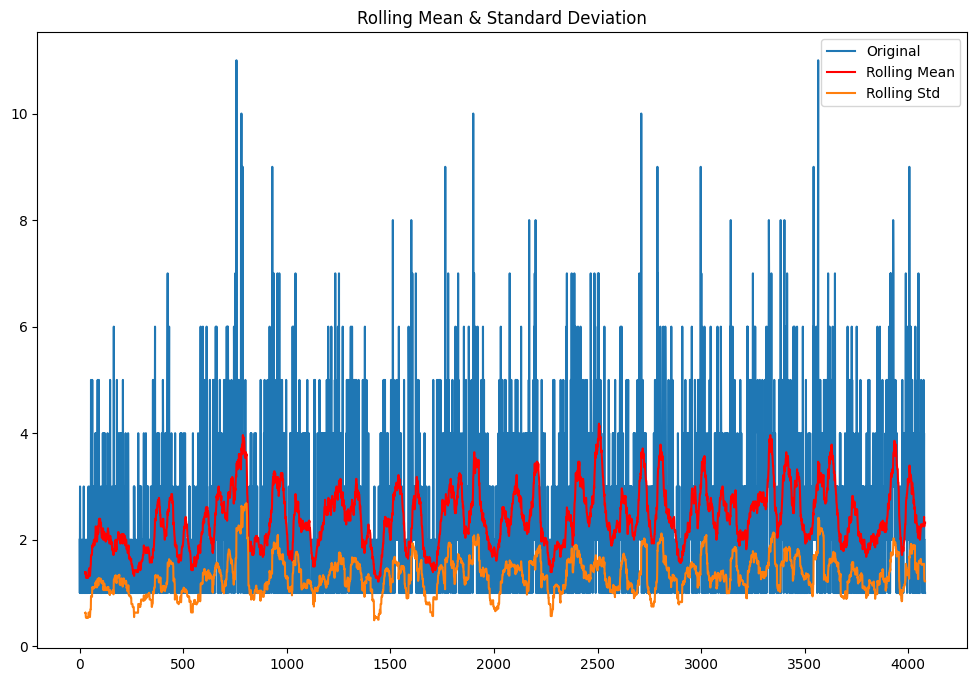

Results of Dickey-Fuller Test:
Test Statistic                -1.104864e+01
p-value                        5.146543e-20
#Lags Used                     1.200000e+01
Number of Observations Used    4.069000e+03
Critical Value (1%)           -3.431958e+00
Critical Value (5%)           -2.862251e+00
Critical Value (10%)          -2.567148e+00
dtype: float64


In [86]:
# Some statistics :
test_stationarity(d.Num_Acc , window = 28)


lag_acf


/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



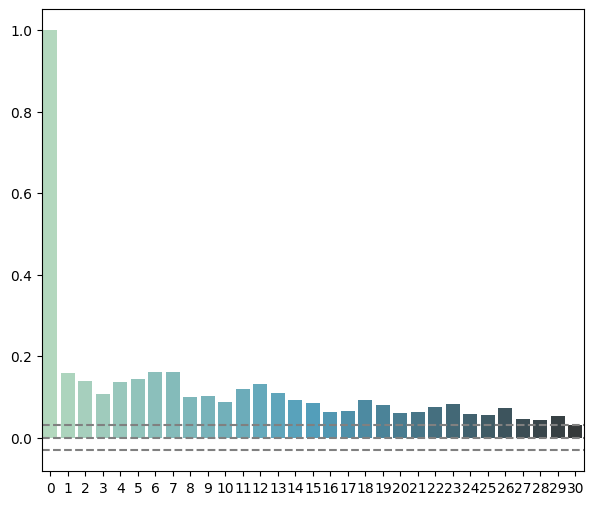

lag_pacf


/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



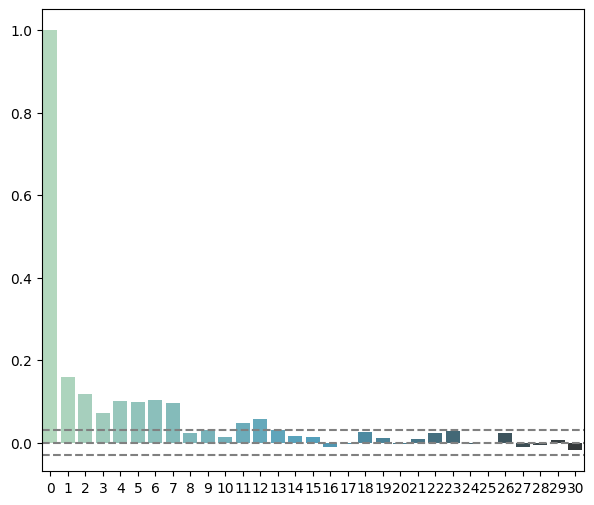

In [87]:
acp_pacp(d.Num_Acc)


## Seasonality

### Hourly

In [88]:
# Préparation de vos données
tempas = data[['Num_Acc' , 'hrmn']]
tempas['hour'] = tempas['hrmn'].apply(lambda x:str(x).zfill(4)[:2])

grave_accs = data[data.grav.isin([2,3])].Num_Acc

tempas['gravity'] = 0
tempas.loc[tempas.Num_Acc.isin(grave_accs),'gravity'] = 1

occs = tempas.drop('hrmn' , axis = 1).groupby('hour' , as_index = False).agg({'Num_Acc' : 'count' , 'gravity' : 'sum'})

# Création des tracés en aires
trace1 = go.Scatter(
    x=list(occs.hour),  # Axe des abscisses
    y=list(occs.Num_Acc),  # Axe des ordonnées
    mode='lines',
    name='Total Number of Accidents',
    fill='tozeroy',
    marker=dict(color='rgb(106,81,163)'),
)

trace2 = go.Scatter(
    x=list(occs.hour),  # Axe des abscisses
    y=list(occs.gravity),  # Axe des ordonnées
    mode='lines',
    name='Grave Accidents',
    fill='tozeroy',
    marker=dict(color='rgb(255,0,0)')
)

# Configuration de la mise en page
layout = go.Layout(
    title='Repartition of Accidents per Hour',
    autosize=False,
    width=1000,
    height=500,
)

# Création de la figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Affichage du graphique
fig.show()


/var/folders/jg/x3y4bp6n6071zs7rycbnfsyc0000gn/T/ipykernel_2930/2204788337.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jg/x3y4bp6n6071zs7rycbnfsyc0000gn/T/ipykernel_2930/2204788337.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Daily

In [89]:
tempas = data[['dep', 'Num_Acc']]


In [90]:
tempas['date'] = pd.to_datetime((2000+data.an)*10000+data.mois*100+data.jour,format='%Y%m%d')
tempas['weekday'] = tempas['date'].dt.weekday.apply(lambda x:str(x).zfill(2))

tempas['gravity'] = 0
tempas.loc[tempas.Num_Acc.isin(grave_accs),'gravity'] = 1

occs = tempas.drop('date' , axis = 1).groupby('weekday' , as_index = False).agg({'Num_Acc' : 'count' , 'gravity' : 'sum'})


/var/folders/jg/x3y4bp6n6071zs7rycbnfsyc0000gn/T/ipykernel_2930/4027764998.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jg/x3y4bp6n6071zs7rycbnfsyc0000gn/T/ipykernel_2930/4027764998.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jg/x3y4bp6n6071zs7rycbnfsyc0000gn/T/ipykernel_2930/4027764998.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [91]:
# Création des tracés en aires
trace1 = go.Scatter(
    x=list(occs.weekday),  # Axe des abscisses
    y=list(occs.Num_Acc),  # Axe des ordonnées
    mode='lines',
    name='Total Number of Accidents',
    fill='tozeroy',
    marker=dict(color='rgb(106,81,163)'),
)

trace2 = go.Scatter(
    x=list(occs.weekday),  # Axe des abscisses
    y=list(occs.gravity),  # Axe des ordonnées
    mode='lines',
    name='Grave Accidents',
    fill='tozeroy',
    marker=dict(color='rgb(255,0,0)')
)

# Configuration de la mise en page
layout = go.Layout(
    title='Repartition of Accidents per weekday',
    autosize=False,
    width=1000,
    height=500,
)

# Création de la figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Affichage du graphique
fig.show()


### Monthly

In [92]:
tempas = data[['Num_Acc' , 'mois']]
tempas['mois'] = tempas['mois'].apply(lambda x:str(x).zfill(2))

tempas['gravity'] = 0
tempas.loc[tempas.Num_Acc.isin(grave_accs),'gravity'] = 1


occs = tempas.groupby('mois' , as_index = False).agg({'Num_Acc' : 'count' , 'gravity' : 'sum'})


/var/folders/jg/x3y4bp6n6071zs7rycbnfsyc0000gn/T/ipykernel_2930/642580494.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jg/x3y4bp6n6071zs7rycbnfsyc0000gn/T/ipykernel_2930/642580494.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [93]:
# Création des tracés en aires
trace1 = go.Scatter(
    x=list(occs.mois),  # Axe des abscisses
    y=list(occs.Num_Acc),  # Axe des ordonnées
    mode='lines',
    name='Total Number of Accidents',
    fill='tozeroy',
    marker=dict(color='rgb(106,81,163)'),
)

trace2 = go.Scatter(
    x=list(occs.mois),  # Axe des abscisses
    y=list(occs.gravity),  # Axe des ordonnées
    mode='lines',
    name='Grave Accidents',
    fill='tozeroy',
    marker=dict(color='rgb(255,0,0)')
)

# Configuration de la mise en page
layout = go.Layout(
    title='Repartition of Accidents per weekday',
    autosize=False,
    width=1000,
    height=500,
)

# Création de la figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Affichage du graphique
fig.show()


## Modeling

In [94]:
def evaluate(y_true , y_pred , dates):

    try:
        true_value , prediction = y_true.sum(axis = 1), y_pred.sum(axis=1).round()
    except:
        true_value , prediction = y_true, y_pred.round()

    print('Mean Absolute Error   :' , round(abs(true_value - prediction).mean() , 2))
    print('Root Mean Square Error:' , round(sqrt(((true_value - prediction)**2).mean()) , 2) )
    print('Mean Percentage Error :' , round((abs(true_value - prediction)/true_value).mean() , 2)  )

    error = pd.Series(true_value - prediction)

    #density plot :
    print('Error Density :')
    error.plot.density()
    plt.show()

    # mean of error and correlation :
    print('Mean Error                       :' , round(mean(error) , 2 ))
    print('True Value And error Correlation :' , round(np.corrcoef(error , true_value)[0 , 1] , 2))

    # plot :

    to_plot = pd.DataFrame({'target' : y_true.reshape(-1) , 'prediction' : y_pred.reshape(-1)})

    jsplot_multiple(dates , to_plot)


### Naive Model

### Prophet

In [95]:
from prophet import Prophet


In [160]:
# arrondissement_data = data[data['com'] == 109]
# daily_accidents = arrondissement_data.groupby('an').size().reset_index(name='count')

# daily_accidents.columns = ['ds', 'y']

# model = Prophet(yearly_seasonality=True , weekly_seasonality=True, daily_seasonality=False)
# model.fit(daily_accidents)
# future = model.make_future_dataframe(periods=365)  # Prédire pour l'année suivante
# forecast = model.predict(future)
# model.plot(forecast)


DEBUG:cmdstanpy:input tempfile: /var/folders/jg/x3y4bp6n6071zs7rycbnfsyc0000gn/T/tmpg94bjhz0/fje81_sr.json
DEBUG:cmdstanpy:input tempfile: /var/folders/jg/x3y4bp6n6071zs7rycbnfsyc0000gn/T/tmpg94bjhz0/7ebzah5x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24351', 'data', 'file=/var/folders/jg/x3y4bp6n6071zs7rycbnfsyc0000gn/T/tmpg94bjhz0/fje81_sr.json', 'init=/var/folders/jg/x3y4bp6n6071zs7rycbnfsyc0000gn/T/tmpg94bjhz0/7ebzah5x.json', 'output', 'file=/var/folders/jg/x3y4bp6n6071zs7rycbnfsyc0000gn/T/tmpg94bjhz0/prophet_model04zj24ya/prophet_model-20231218164844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:48:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:48:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Ch

Mean Absolute Error   : 1.03
Root Mean Square Error: 1.4
Mean Percentage Error : 0.59
Error Density :


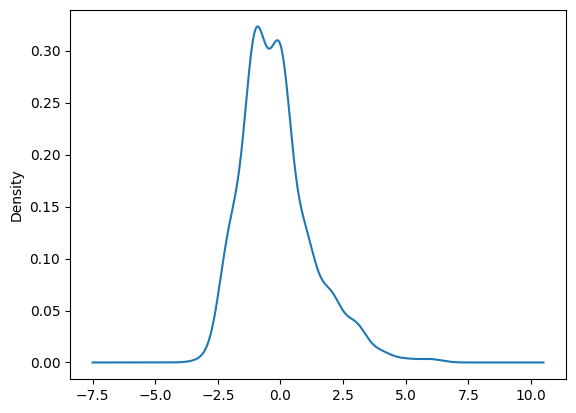

Mean Error                       : -0.15
True Value And error Correlation : 0.92


In [169]:
#Initialisation of the model.
model = Prophet(yearly_seasonality=True , weekly_seasonality=True, daily_seasonality=False)

#train & test set.
histo , new = d[d.day.dt.year < 2018].reset_index(drop = True) , d[d.day.dt.year == 2018].reset_index(drop = True)

# We rename the columns before fitting the model to Prophet.
ncols = histo.columns.values
ncols[0] , ncols[1] = 'ds' , 'y'

histo.columns , new.columns = ncols , ncols

# We fit the model.
model.fit(histo)


# Prediction
ypred = model.predict(new)['yhat'].round()

# Evaluation
evaluate(new.y.values , ypred.values , d.day[-365:])


### LSTM(Long short-term memory networks)

In [97]:
"""Reshaping datas 2D to 3D input"""
def reshape_timeseries(series , target_ids, window_size , take_curr = True , scale = True):


    # Converting the dataset to a suitable format :
    X = series.values
    Y = series.iloc[ : , target_ids].values

    # Scaling the data
    if scale:
        maxes = Y.max(axis = 0)
        Y = np.divide( Y , maxes)
        X = MinMaxScaler().fit_transform(X)

    # Conversion to time series with keras object
    ts = TimeseriesGenerator(X , Y , length = window_size , batch_size = X.shape[0])
    X , Y = ts[0]

    # Masking
    if take_curr:
        for timestep in X[: , window_size - 1]:
            timestep[target_ids] = [-2 for i in target_ids]
    else:
        X = X[: , :-1]

    if scale:
        return X , Y , maxes

    return X,Y


In [98]:
"""Building the model"""
def model(X , Y , learning_rate = 0.001,
          lstm_layers = [] , lstm_dropout = [],
          dense_layers = [] , dense_dropout = [] ,
          ntest_day = 365 , epochs = 10 , batch_size = 32):


    # training and testing set :
    length , timesteps , features = X.shape[0] , X.shape[1] , X.shape[2]
    target_shape = Y.shape[1]

    # Validation rate to pass to the Sequential Model :
    val_rate = ntest_day/length


    ############################################ Model :

    checkpoint = ModelCheckpoint('model' , save_best_only=True)

    model = Sequential()

    # Masking Layer.
    model.add(Masking(mask_value = -2 , input_shape=(X.shape[1],  X.shape[2])    ))


    # BI-LSTM Layers.
    for i in range(len(lstm_layers)):
        rsequs  = not (i == (len(lstm_layers) - 1))
        model.add(Bidirectional( LSTM(lstm_layers[i] , return_sequences = rsequs) ,input_shape=(X.shape[1], X.shape[2]) ) )
        model.add(Dropout(lstm_dropout[i]))


    # Dense Layers.
    for i in range(len(dense_layers)):
        model.add(Dense(dense_layers[i]) )
        model.add(Dropout(dense_dropout[i]))
        model.add(Activation('relu'))


    model.add(Dense(target_shape))
    Nadam = keras.optimizers.Nadam(learning_rate = learning_rate , beta_1=0.9, beta_2=0.999, epsilon=1e-08)#, schedule_decay=0.0004)
    model.compile(loss='mean_squared_error', optimizer='adam')

    print('Model Summary:')
    print(model.summary())

    # fitting the data
    print('\n\n Training :')
    model.fit(X, Y, epochs= epochs, batch_size=batch_size, validation_split = val_rate, callbacks = [checkpoint])


    # loading best_model
    model = load_model('model')

    return model


Model Summary:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_3 (Masking)         (None, 28, 20)            0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 40)               6560      
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 40)                0         
                                                                 
 dense_6 (Dense)             (None, 500)               20500     
                                                                 
 dropout_9 (Dropout)         (None, 500)               0         
                                                                 
 activation_3 (Activation)   (None, 500)               0         
                                       

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


58/58 [==============================] - 89s 1s/step - loss: 0.0216 - val_loss: 0.0174
Epoch 2/20
57/58 [============================>.] - ETA: 0s - loss: 0.0184

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


58/58 [==============================] - 42s 736ms/step - loss: 0.0183 - val_loss: 0.0166
Epoch 3/20
58/58 [==============================] - 1s 20ms/step - loss: 0.0179 - val_loss: 0.0171
Epoch 4/20
57/58 [============================>.] - ETA: 0s - loss: 0.0172

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


58/58 [==============================] - 41s 712ms/step - loss: 0.0172 - val_loss: 0.0164
Epoch 5/20
58/58 [==============================] - ETA: 0s - loss: 0.0167

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


58/58 [==============================] - 41s 715ms/step - loss: 0.0167 - val_loss: 0.0162
Epoch 6/20
55/58 [===========================>..] - ETA: 0s - loss: 0.0166

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


58/58 [==============================] - 42s 740ms/step - loss: 0.0165 - val_loss: 0.0159
Epoch 7/20
58/58 [==============================] - 1s 18ms/step - loss: 0.0167 - val_loss: 0.0162
Epoch 8/20
58/58 [==============================] - ETA: 0s - loss: 0.0166

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


58/58 [==============================] - 42s 737ms/step - loss: 0.0166 - val_loss: 0.0158
Epoch 9/20
58/58 [==============================] - 1s 19ms/step - loss: 0.0165 - val_loss: 0.0165
Epoch 10/20
58/58 [==============================] - 1s 18ms/step - loss: 0.0165 - val_loss: 0.0171
Epoch 11/20
58/58 [==============================] - ETA: 0s - loss: 0.0163

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


58/58 [==============================] - 45s 794ms/step - loss: 0.0163 - val_loss: 0.0157
Epoch 12/20
57/58 [============================>.] - ETA: 0s - loss: 0.0160

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


58/58 [==============================] - 42s 732ms/step - loss: 0.0160 - val_loss: 0.0156
Epoch 13/20
58/58 [==============================] - 1s 18ms/step - loss: 0.0158 - val_loss: 0.0164
Epoch 14/20
58/58 [==============================] - 1s 25ms/step - loss: 0.0158 - val_loss: 0.0163
Epoch 15/20
56/58 [===========================>..] - ETA: 0s - loss: 0.0161

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


58/58 [==============================] - 45s 789ms/step - loss: 0.0160 - val_loss: 0.0156
Epoch 16/20
56/58 [===========================>..] - ETA: 0s - loss: 0.0156

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


58/58 [==============================] - 44s 766ms/step - loss: 0.0156 - val_loss: 0.0153
Epoch 17/20
58/58 [==============================] - 1s 21ms/step - loss: 0.0158 - val_loss: 0.0155
Epoch 18/20
58/58 [==============================] - 1s 22ms/step - loss: 0.0157 - val_loss: 0.0165
Epoch 19/20
58/58 [==============================] - 1s 22ms/step - loss: 0.0155 - val_loss: 0.0157
Epoch 20/20
58/58 [==============================] - 1s 23ms/step - loss: 0.0156 - val_loss: 0.0157


2023-12-18 14:59:59.665953: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-12-18 15:00:01.530999: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-12-18 15:00:03.385639: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-12-18 15:00:07.222521: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-12-18 15:00:07.265103: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_sh

12/12 [==============================] - 6s 5ms/step
Mean Absolute Error   : 1.03
Root Mean Square Error: 1.39
Mean Percentage Error : 0.57
Error Density :


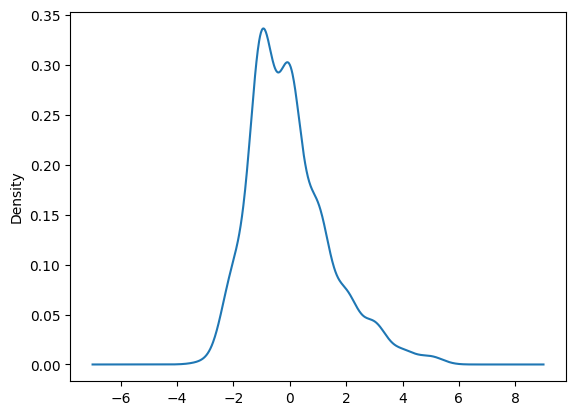

Mean Error                       : -0.02
True Value And error Correlation : 0.92


In [101]:
X , Y , maxes  = reshape_timeseries(d.iloc[:, 1:] , [0], window_size = 28 , take_curr = True , scale = True)
ntest_day = 365

nmodel = model(X , Y , learning_rate = 0.002, lstm_layers = [20 ] , lstm_dropout = [.3 ] ,
               dense_layers = [500] , dense_dropout = [.5] , batch_size = 64 , epochs = 20)

# Computing Validation scores : MAE - RMSE - MPE
y_predict = nmodel.predict(X[- ntest_day:]) * maxes
y_true = Y[- ntest_day:] * maxes

evaluate(y_true , y_predict , d.day[-365:])


The performances are roughly the same than Prophet. But the prediction made here is a day+1 prediction rather than a prediction of the whole year like we made with Prophet. So let's right a function that will predict the next year step by step:

In [102]:
def long_term_prediction(model , X , nb_target):
#Function also adapted to multiple targets
    predictions = []
    new_line = X[0].reshape(1 , *X.shape[1:])
    pred = model.predict(new_line)
    predictions.append(pred)

    for line in X[1:]:
        old_line = deepcopy(line)
        old_line[-2 , :nb_target] = pred
        pred= model.predict(old_line.reshape(1 , *X.shape[1:]))
        predictions.append(pred)

    return np.array(predictions).reshape(-1 , nb_target )


1/1 [==============================] - 0s 22ms/step
Mean Absolute Error   : 1.03
Root Mean Square Error: 1.39
Mean Percentage Error : 0.58
Error Density :


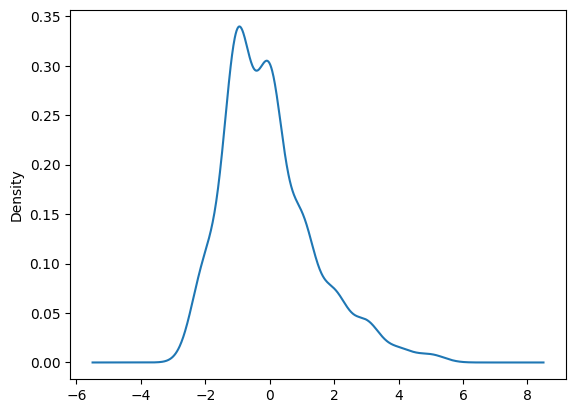

Mean Error                       : -0.04
True Value And error Correlation : 0.92


In [103]:
# Computing Validation scores : MAE - RMSE - MPE
y_predict = long_term_prediction(nmodel , X[- ntest_day:] , 1)* maxes
y_true = Y[- ntest_day:] * maxes

evaluate(y_true , y_predict , d.day[-365:])


We can see that the results are stable and almost the same as Prophet. Let's try another way to model our problem with LSTMs:

### Multivariate Time series with LSTMs:

What if we want to get an approximate location of future accidents ? This would be a highly valuable information if we want to take preventive measures. Paris is made up of 20 separate districts. Instead of predicting the sum of the total number of accidents, we are going to predict the number of accidents in each district in a multivariate way. This means that instead of outputting a single neuron, our model will output 20 neurons, each one representing a district. To score the model, we are going to sum the predictions and see if we get good results.

In [116]:
import geohash2


In [161]:
# Taille de la grille
grid_height = 10
grid_width = 10
desired_precision = 12
# Coordonnées limites de Paris
nord = 48.9121449
sud = 48.815573
est = 2.4439169
ouest = 2.26122

# Calculer la dimension de chaque zone
lat_step = (nord - sud) / grid_height  # grid_height: nombre de zones en latitude
lon_step = (est - ouest) / grid_width  # grid_width: nombre de zones en longitude

# Créer les géohash
geohashes = []
for i in range(grid_height):
    for j in range(grid_width):
        lat = sud + i * lat_step
        lon = ouest + j * lon_step
        geohashes.append(geohash2.encode(lat, lon, precision=desired_precision))

# Afficher les 6 premiers géohash
for geo in geohashes[:6]:
    print(geo)


u09teqwe64rg
u09teyeg7fqe
u09tsq95mdme
u09tsww7r6k7
u09ttneg3477
u09ttw956f65


In [ ]:
map = folium.Map(location=[48.8566, 2.3522], zoom_start=12)
for gh in geohashes:
    lat, lon = geohash2.decode(gh)
    folium.Marker([lat, lon], popup=gh).add_to(map)

map


In [104]:
cdtsers = data[['Num_Acc' , 'dep', 'com', 'jour' , 'mois' , 'an']]


cdtsers['day'] = pd.to_datetime((2000+cdtsers.an)*10000+cdtsers.mois*100+cdtsers.jour,format='%Y%m%d')
cdtsers.drop(['jour' , 'mois' , 'an'] , axis = 1 ,inplace = True)

def correct(x):
    if x>100:
        return x - 100
    return x

cdtsers.com = cdtsers.com.apply( correct )

cdtsers = cdtsers.groupby(['day' , 'dep' , 'com'] , as_index = False).count()

cdtsers = cdtsers.pivot_table(index = ['day' , 'dep'] , columns = 'com' , values = 'Num_Acc').reset_index()

cdtsers.fillna(0).head()

cdtsers['weekday'] = cdtsers.day.dt.weekday
cdtsers['month'] = cdtsers.day.dt.month
cdtsers = pd.get_dummies(cdtsers , columns = ['weekday' , 'month'])


/var/folders/jg/x3y4bp6n6071zs7rycbnfsyc0000gn/T/ipykernel_2930/4152996018.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jg/x3y4bp6n6071zs7rycbnfsyc0000gn/T/ipykernel_2930/4152996018.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jg/x3y4bp6n6071zs7rycbnfsyc0000gn/T/ipykernel_2930/4152996018.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [109]:
X , Y , maxes  = reshape_timeseries(cdtsers.iloc[: , 1:] , list(range(19)), window_size = 28 , take_curr = True , scale = True)

ntest_day = 365

nmodel = model(X , Y , learning_rate = 0.005, lstm_layers = [64 , 64] , lstm_dropout = [.2 , .2] ,
               dense_layers = [64] , dense_dropout = [.2] , batch_size = 64 , epochs = 20)


Model Summary:
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_6 (Masking)         (None, 28, 39)            0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 28, 128)          53248     
 onal)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 28, 128)           0         
                                                                 
 bidirectional_11 (Bidirecti  (None, 128)              98816     
 onal)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 64)

KeyboardInterrupt: 

In [108]:
# Evaluating:
y_predict = (nmodel.predict(X[- ntest_day:]) * maxes).sum(axis = 1)
y_true = (Y[- ntest_day:] * maxes).sum(axis = 1)

evaluate(y_true , y_predict , cdtsers.day[-365:])


ValueError: in user code:

    File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 28, 20), found shape=(None, 28, 39)


In [81]:
# Evaluating on long term:
y_predict =( long_term_prediction(nmodel , X[- ntest_day:] , 19)* maxes).sum(axis = 1)
y_true = (Y[- ntest_day:] * maxes).sum(axis = 1)

evaluate(y_true , y_predict , cdtsers.day[-365:])


ValueError: in user code:

    File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 28, 20), found shape=(None, 28, 40)


We get the same performance than the previous model, but we have an additional information which is the number of accidents per district.
A COUPLER avec geohashing

## Conclusion

The idea I had in the beginning was to build a big neural network where each output neuron would represent a road in France. This would allow the network to learn the dependencies between roads and give us a precise location of future accidents. I still think that it can work and will probably implement it in the future.
I think it would be more beneficial for us to have an hourly model instead of a daily model. The code can easily be modified to make this change.
I'm still trying to retrieve more data, especially traffic data, which will probably greatly improve the results.

In [166]:
data = pd.read_csv('../clean_data/velo_df_paris_final.csv')


In [171]:
def process_dates(df):
    # Vérifier les dates invalides
    invalid_dates = df[(df['jour'] > 31) | ((df['mois'] == 2) & (df['jour'] > 29)) | ((df['mois'].isin([4, 6, 9, 11])) & (df['jour'] > 30))]
    df = df.drop(invalid_dates.index)

    # Créer la colonne 'date'
    df['date'] = pd.to_datetime(df['an'].astype(str).str.zfill(2)
                                + df['mois'].astype(str).str.zfill(2)
                                + df['jour'].astype(str).str.zfill(2)
                                + df['hrmn'].astype(str).str.zfill(4),
                                format='%y%m%d%H%M', errors='coerce')

    df = df.drop(columns=['an', 'mois', 'jour', 'hrmn'])
    return df

# Utiliser la fonction sur carac_df_modif
data_modif = process_dates(data)


In [175]:
data_modif.to_csv('../clean_data/data_modif.csv', index=False)


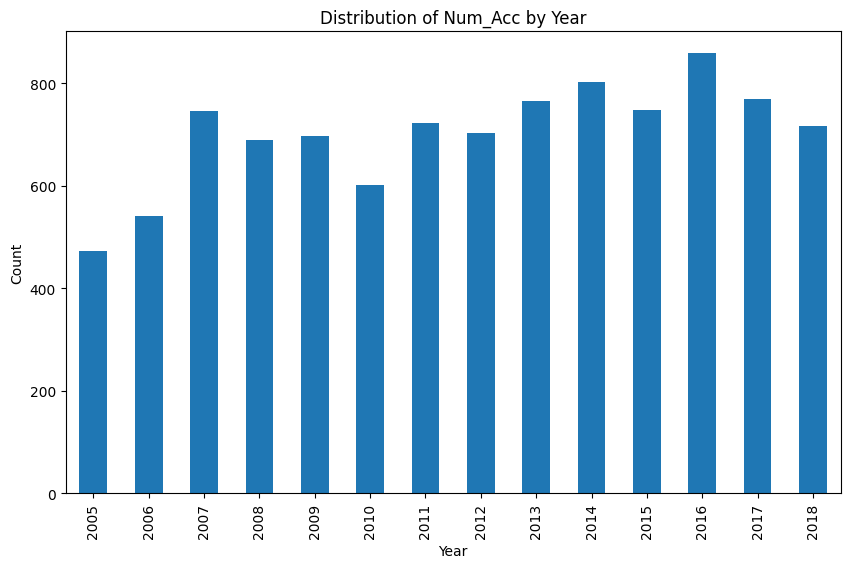

In [176]:
# Group the data by year
data_grouped = data_modif.groupby(data_modif['date'].dt.year)['Num_Acc'].count()

# Plot the distribution
plt.figure(figsize=(10, 6))
data_grouped.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Distribution of Num_Acc by Year')
plt.show()


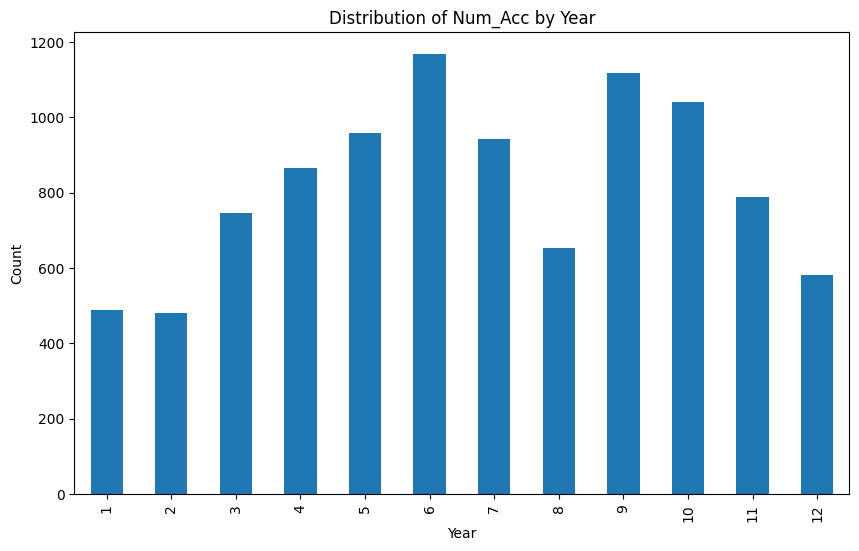

In [177]:
# Group the data by months
data_grouped = data_modif.groupby(data_modif['date'].dt.month)['Num_Acc'].count()

# Plot the distribution
plt.figure(figsize=(10, 6))
data_grouped.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Distribution of Num_Acc by Month')
plt.show()


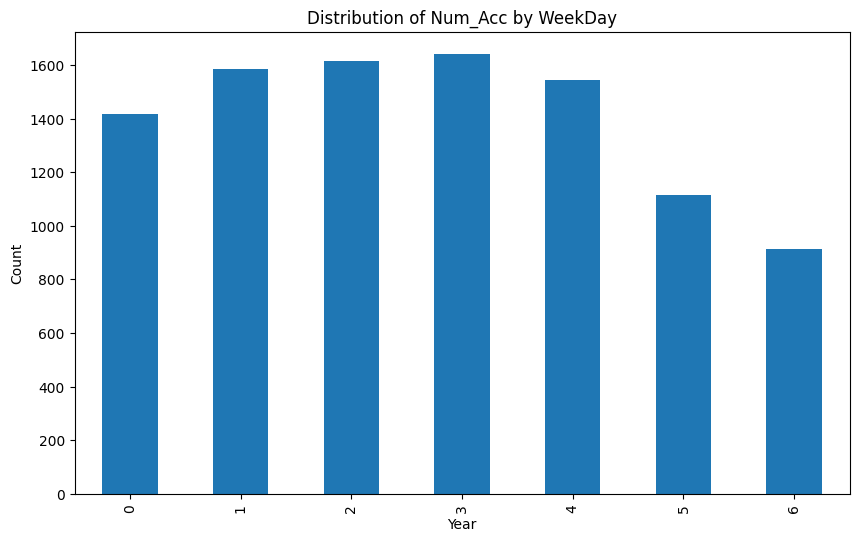

In [180]:
# Group the data by weekday
data_grouped = data_modif.groupby(data_modif['date'].dt.weekday)['Num_Acc'].count()

# Plot the distribution
plt.figure(figsize=(10, 6))
data_grouped.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Distribution of Num_Acc by WeekDay')
plt.show()


<Figure size 1000x600 with 0 Axes>

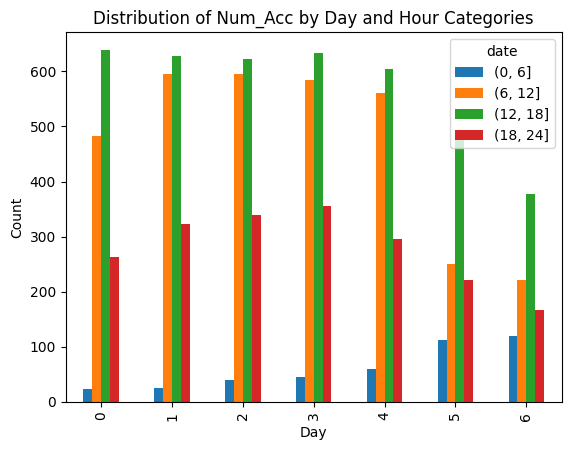

In [181]:
# Group the data by day and hour categories
data_grouped = data_modif.groupby([data_modif['date'].dt.weekday, pd.cut(data_modif['date'].dt.hour, bins=[0, 6, 12, 18, 24])])['Num_Acc'].count()

# Reshape the data for plotting
data_grouped = data_grouped.unstack()

# Plot the distribution
plt.figure(figsize=(10, 6))
data_grouped.plot(kind='bar')
plt.xlabel('Day')
plt.ylabel('Count')
plt.title('Distribution of Num_Acc by Day and Hour Categories')
plt.show()


In [204]:
"""Building the model"""
def model(X , Y , learning_rate = 0.001,
          lstm_layers = [] , lstm_dropout = [],
          dense_layers = [] , dense_dropout = [] ,
          ntest_day = 365 , epochs = 10 , batch_size = 32):


    # training and testing set :
    length , timesteps , features = X.shape[0] , X.shape[1] , X.shape[2]
    target_shape = Y.shape[1]

    # Validation rate to pass to the Sequential Model :
    val_rate = ntest_day/length


    ############################################ Model :

    checkpoint = ModelCheckpoint('model' , save_best_only=True)

    model = Sequential()

    # Masking Layer.
    model.add(Masking(mask_value = -2 , input_shape=(X.shape[1],  X.shape[2])))


    # BI-LSTM Layers.
    for i in range(len(lstm_layers)):
        rsequs  = not (i == (len(lstm_layers) - 1))
        model.add(Bidirectional(LSTM(lstm_layers[i] , return_sequences = rsequs) ,input_shape=(X.shape[1], X.shape[2]) ) )
        model.add(Dropout(lstm_dropout[i]))


    # Dense Layers.
    for i in range(len(dense_layers)):
        model.add(Dense(dense_layers[i]) )
        model.add(Dropout(dense_dropout[i]))
        model.add(Activation('relu'))


    model.add(Dense(target_shape))
    Nadam = keras.optimizers.Nadam(learning_rate = learning_rate , beta_1=0.9, beta_2=0.999, epsilon=1e-08)#, schedule_decay=0.0004)
    model.compile(loss='mean_squared_error', optimizer='adam')

    print('Model Summary:')
    print(model.summary())

    # fitting the data
    print('\n\n Training :')
    model.fit(X, Y, epochs= epochs, batch_size=batch_size, validation_split = val_rate, callbacks = [checkpoint])


    # loading best_model
    model = load_model('model')

    return model

"""Reshaping datas 2D to 3D input"""
def reshape_timeseries(series , target_ids, window_size , take_curr = True , scale = True):


    # Converting the dataset to a suitable format :
    X = series.values
    Y = series.iloc[ : , target_ids].values

    # Scaling the data
    if scale:
        maxes = Y.max(axis = 0)
        Y = np.divide( Y , maxes)
        X = MinMaxScaler().fit_transform(X)

    # Conversion to time series with keras object
    ts = TimeseriesGenerator(X , Y , length = window_size , batch_size = X.shape[0])
    X , Y = ts[0]

    # Masking
    if take_curr:
        for timestep in X[: , window_size - 1]:
            timestep[target_ids] = [-2 for i in target_ids]
    else:
        X = X[: , :-1]

    if scale:
        return X , Y , maxes

    return X,Y


In [191]:
cdtsers = data_modif[['Num_Acc' , 'dep', 'com', 'date']]

def correct(x):
    if x>100:
        return x - 100
    return x

cdtsers.com = cdtsers.com.apply(correct)

cdtsers = cdtsers.groupby(['date' , 'dep' , 'com'] , as_index = False).count()

cdtsers = cdtsers.pivot_table(index = ['date' , 'dep'] , columns = 'com' , values = 'Num_Acc').reset_index()

cdtsers.fillna(0).head()

cdtsers['weekday'] = cdtsers['date'].dt.weekday
cdtsers['month'] = cdtsers['date'].dt.month
cdtsers = pd.get_dummies(cdtsers , columns = ['weekday' , 'month'])


/var/folders/jg/x3y4bp6n6071zs7rycbnfsyc0000gn/T/ipykernel_2930/548020316.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [192]:
X , Y , maxes  = reshape_timeseries(cdtsers.iloc[: , 1:] , list(range(19)), window_size = 28 , take_curr = True , scale = True)

ntest_day = 365

nmodel = model(X , Y , learning_rate = 0.005, lstm_layers = [64 , 64] , lstm_dropout = [.2 , .2] ,
               dense_layers = [64] , dense_dropout = [.2] , batch_size = 64 , epochs = 20)


Model Summary:
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_7 (Masking)         (None, 28, 40)            0         
                                                                 
 bidirectional_12 (Bidirecti  (None, 28, 128)          53760     
 onal)                                                           
                                                                 
 dropout_19 (Dropout)        (None, 28, 128)           0         
                                                                 
 bidirectional_13 (Bidirecti  (None, 128)              98816     
 onal)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 64)

2023-12-18 17:52:49.031770: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-12-18 17:52:51.443028: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-12-18 17:52:54.660514: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-12-18 17:52:58.736517: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-12-18 17:52:58.774231: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_sh

In [193]:
# Evaluating:
y_predict = (nmodel.predict(X[- ntest_day:]) * maxes).sum(axis = 1)
y_true = (Y[- ntest_day:] * maxes).sum(axis = 1)

evaluate(y_true , y_predict , cdtsers.date[-365:])


ValueError: in user code:

    File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 28, 20), found shape=(None, 28, 40)


In [194]:
# Evaluating on long term:
y_predict =( long_term_prediction(nmodel , X[- ntest_day:] , 19)* maxes).sum(axis = 1)
y_true = (Y[- ntest_day:] * maxes).sum(axis = 1)

evaluate(y_true , y_predict , cdtsers.date[-365:])


ValueError: in user code:

    File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 28, 20), found shape=(None, 28, 40)
